In [1]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
# import visualkeras

import datetime
import ephem

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pypalettes 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import json
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfea
import pyproj
import imageio.v2 as imageio
from io import BytesIO
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from scipy.stats import gaussian_kde, anderson_ksamp, cramervonmises_2samp
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import genextreme as gev
from scipy.stats import genpareto

import custom_functions as cf
import custom_for_model as cfm
import custom_generator as cgen
import pickle

palette = "Prism"
# cmap = pypalettes.load_cmap(palette, type="continuous", keep=[True, True, True, True, True, True, True])
palette_hex_list = pypalettes.get_hex(palette)
cmap_name = 'cmap_sealevel'
cmap_hex_list = [palette_hex_list[5],palette_hex_list[6],palette_hex_list[2],palette_hex_list[1],palette_hex_list[0]]
rgb_colors = [mcolors.hex2color(color) for color in cmap_hex_list]
cmap = LinearSegmentedColormap.from_list(cmap_name, rgb_colors, N=256)

# Load settings
with open('settings_future.json', 'r') as file:
    settings = json.load(file)

ImportError: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.

**Prism pypalette**<br>
<img src="Data/prism.png" alt="prism" width="300"/>

In [3]:
data_path= settings["data_path"]
output_path=settings["output_path"]
img_path=settings["img_path"]
local_data_path= os.getcwd()+'/Data/'

lat = settings["lat"]
lon = settings["lon"]

In [4]:
train_y_bounds = settings["train_y_bounds"]
train_month_start_end = settings["train_month_start_end"]
LSTM_recurrent_steps = settings["LSTM_recurrent_steps"]
ms_recurrent_steps = settings["ms_recurrent_steps"]
output_type = bool(settings["output_type"])
preprocess = settings["preprocess"]
kfold = bool(settings["kfold"])
folds_number = settings["folds_number"]

if output_type:
   y_shape=2
else:
   y_shape=1

model_type = settings["model_type"]  # can be: conv, lstm, conv-lstm
# constrain n_recurrent_setps equal for each variable for lstm and conv-lstm
if (model_type=="lstm" or model_type=="conv-lstm"):
   LSTM_recurrent_steps= max(LSTM_recurrent_steps,ms_recurrent_steps)
   ms_recurrent_steps= max(LSTM_recurrent_steps,ms_recurrent_steps)

seed=42

In [5]:
# LE TRAIETTORIE SONO DELLA SECONDA COMBINAZIONE!


# models_to_analyze = [["dense_5folds_bbox1015_steps24_loss_mse", "dense_5folds_bbox11_steps240_loss_mse"]]
#models_to_analyze = [["dense_5folds_bbox1015_steps24_loss_mse", "dense_5folds_bbox11_steps240_loss_mse"]]
models_to_analyze = [[["dense_5folds_bbox1015_steps24_loss_mse", "dense_5folds_bbox11_steps240_loss_mse"]],
                     [["conv_5folds_bbox1015_steps24_loss_mcql2", "dense_5folds_bbox11_steps240_loss_mse"]],
                     [["dense_5folds_bbox1015_steps24_loss_mse", "dense_5folds_bbox11_steps240_loss_mse"]],
                     [["conv_5folds_bbox1015_steps24_loss_mcql2", "dense_5folds_bbox11_steps240_loss_mse"]]]



out_variables=["only tide", "storm surge"]


In [6]:
if preprocess=="normalize":
    with open(local_data_path+'kfold_global_min.pkl', 'rb') as file:
        kfold_global_min = pickle.load(file)
    with open(local_data_path+'kfold_global_max.pkl', 'rb') as file:
        kfold_global_max = pickle.load(file)

if preprocess=="standardize":
    with open(local_data_path+'kfold_global_mean_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'rb') as file:
        kfold_global_mean = pickle.load(file)
    with open(local_data_path+'kfold_global_std_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'rb') as file:
        kfold_global_std = pickle.load(file)

if preprocess=="robustscaling":
    with open(local_data_path+'kfold_global_mean.pkl', 'rb') as file:
        kfold_global_mean = pickle.load(file)
    with open(local_data_path+'kfold_global_iqr.pkl', 'rb') as file:
        kfold_global_iqr = pickle.load(file)

## Regression metrics

## __________________________________________________________________________________________________________

In [7]:
def quantile_loss(y_true, y_pred, quantile):
    return tf.maximum(quantile * (y_true - y_pred), (1-quantile) * (y_pred - y_true))

def composite_quantile_loss(y_true, y_pred, quantiles):
    N = y_true.shape[0]
    K = len(quantiles)
    loss = 0
    for k in range(K):
        tau = quantiles[k]
        loss += tf.reduce_sum(quantile_loss(y_true, y_pred, tau)).numpy()
    composite_loss = loss / (N * K)
    return composite_loss

def ratio_of_99th_quantiles(y1, y2,quantile_for_ratio):
    q99_y1 = np.percentile(y1, quantile_for_ratio)
    q99_y2 = np.percentile(y2, quantile_for_ratio)
    if q99_y2 == 0:
        raise ValueError("y2 quantile is 0")
    return q99_y1 / q99_y2

quantiles = [0.75, 0.95]
quantile_for_ratio=0.99



#### Cronological order of k-folds

In [8]:


# _________________________LOAD_INDICIES_____________________________________________________
# load
train_val_indices = np.load(local_data_path+'train_val_indices.npy')
test_indices = np.load(local_data_path+'test_indices.npy')
arrays_train_indicies = np.load(local_data_path+'arrays_train_indicies.npy', allow_pickle=True).item()
arrays_val_indicies = np.load(local_data_path+'arrays_val_indicies.npy', allow_pickle=True).item()
k = 0

start_date = '2016-02-01 00:00'  # Data e ora di inizio
end_date = '2050-12-31 23:00'    # Data e ora di fine

# CMCC N.A. 2037/12/29 13:00:00 - 2037/12/31 23:00:00

date_range = pd.date_range(start=start_date, end=end_date, freq='h')
date_array = date_range.to_numpy()  # Converte l'oggetto DatetimeIndex in un array numpy

# Specifica dei nomi delle colonne
column_names = ['k1', 'k2', 'k3', 'k4', 'k5']
df_surge = pd.DataFrame(index=date_range, columns=column_names)
df_surge[:] = np.nan
df_tide = pd.DataFrame(index=date_range, columns=column_names)
df_tide[:] = np.nan
df_surge_pred = pd.DataFrame(index=date_range, columns=column_names)
df_surge_pred[:] = np.nan
df_tide_pred = pd.DataFrame(index=date_range, columns=column_names)
df_tide_pred[:] = np.nan


In [9]:
GCM_model = "CMCC-CM2-VHR4"
member_cmip6 = "r1i1p1f1"

In [10]:
# Additional score MAE or RMSE
additional_score = "RMSE"


train_scores = [[[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]]

train_scores_tide = [[[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]]

train_scores_surge = [[[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]]

train_scores_wl = [[[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],
                [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]]

GTSM_traj = [[[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]],
             [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]],
             [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]],
             [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]]]

SURROGATE_traj = [[[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]],
                [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]],
                [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]],
                [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]]]

for j in range(0,4):
    for i in range(len(models_to_analyze[j])):

        # _________________________LOAD_INDICIES_____________________________________________________
        k = 0
        # _________________________LOAD_INDICIES_____________________________________________________

        for fold in range(folds_number):
            k = k+1
            # Usa gli indici generati da KFold per creare i set di training e validation
            date_train = date_array

            # Load y
            y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_'+GCM_model+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
            y_train= np.load(y_train_name)
            
            data_series = pd.Series(y_train[:,1])
            y_train[:,1] = data_series.fillna(data_series.rolling(window=3, min_periods=1).mean()).to_numpy()
            data_series = pd.Series(y_train[:,0])
            y_train[:,0] = data_series.fillna(data_series.rolling(window=3, min_periods=1).mean()).to_numpy()
            y_train = y_train[1:,:]
            GTSM_traj[j][fold][0].append(y_train[:,0])
            GTSM_traj[j][fold][1].append(y_train[:,1])

            # Load inferenced values
            model_type = models_to_analyze[j][i][0] # surge model
            model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
            if j >=2:
                y_name = model_path+"y_tuned_"+GCM_model+"_"+member_cmip6+"_k"+str(fold)+"_predict.npy"
            else:
                y_name = model_path+"y_"+GCM_model+"_"+member_cmip6+"_k"+str(fold)+"_predict.npy"
            y_train_predict=np.load(y_name)  

            model_type = models_to_analyze[j][i][0] # tide model
            model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
            if j >=2:
                y_name = model_path+"y_"+GCM_model+"_"+member_cmip6+"_k"+str(fold)+"_predict.npy"
            else:
                y_name = model_path+"y_"+GCM_model+"_"+member_cmip6+"_k"+str(fold)+"_predict.npy"
            tmp_y_train_predict=np.load(y_name)  
            y_train_predict[:,0]=tmp_y_train_predict[:,0]
            # print(y_train_predict)
            del tmp_y_train_predict

            if preprocess=="standardize":
                y_train_predict[:,0] = y_train_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_train_predict[:,1] = y_train_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])  
            y_train_predict = y_train_predict[1:,:]
            SURROGATE_traj[j][fold][0].append(y_train_predict[:,0])
            SURROGATE_traj[j][fold][1].append(y_train_predict[:,1])
            
            # MSE
            
            

            train_scores[j][fold][0].append(mean_squared_error(y_train,y_train_predict))
            train_scores_tide[j][fold][0].append(mean_squared_error(y_train[:,0],y_train_predict[:,0]))
            train_scores_surge[j][fold][0].append(mean_squared_error(y_train[:,1],y_train_predict[:,1]))
            train_scores_wl[j][fold][0].append(mean_squared_error(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1]))
            # monotone composite quantile loss
            train_scores[j][fold][1].append(composite_quantile_loss(y_train,y_train_predict,quantiles))
            train_scores_tide[j][fold][1].append(composite_quantile_loss(y_train[:,0],y_train_predict[:,0],quantiles))
            train_scores_surge[j][fold][1].append(composite_quantile_loss(y_train[:,1],y_train_predict[:,1],quantiles))
            train_scores_wl[j][fold][1].append(composite_quantile_loss(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1],quantiles))
            # quantile ratio
            train_scores[j][fold][2].append(ratio_of_99th_quantiles(y_train,y_train_predict,quantile_for_ratio))
            train_scores_tide[j][fold][2].append(ratio_of_99th_quantiles(y_train[:,0],y_train_predict[:,0],quantile_for_ratio))
            train_scores_surge[j][fold][2].append(ratio_of_99th_quantiles(y_train[:,1],y_train_predict[:,1],quantile_for_ratio))
            train_scores_wl[j][fold][2].append(ratio_of_99th_quantiles(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1],quantile_for_ratio))
            if additional_score=="MAE":
                # MAE
                train_scores[j][fold][3].append(mean_absolute_error(y_train,y_train_predict))
                train_scores_tide[j][fold][3].append(mean_absolute_error(y_train[:,0],y_train_predict[:,0]))
                train_scores_surge[j][fold][3].append(mean_absolute_error(y_train[:,1],y_train_predict[:,1]))
                train_scores_wl[j][fold][3].append(mean_absolute_error(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1]))
            if additional_score=="RMSE":
                # RMSE
                train_scores[j][fold][3].append(root_mean_squared_error(y_train,y_train_predict))
                train_scores_tide[j][fold][3].append(root_mean_squared_error(y_train[:,0],y_train_predict[:,0]))
                train_scores_surge[j][fold][3].append(root_mean_squared_error(y_train[:,1],y_train_predict[:,1]))
                train_scores_wl[j][fold][3].append(root_mean_squared_error(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1]))


        # save scores
        with open(model_path+'train_scores.pkl', 'wb') as f:
            pickle.dump(train_scores, f)
        with open(model_path+'train_scores_tide.pkl', 'wb') as f:
            pickle.dump(train_scores_tide, f)
        with open(model_path+'train_scores_surge.pkl', 'wb') as f:
            pickle.dump(train_scores_surge, f)


        # # Load score
        # with open('lista.pkl', 'rb') as f:
        #     loaded_list = pickle.load(f)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che `train_scores_surge` sia una lista a 3 dimensioni: [j][fold][4]
# Dati di esempio (rimuovere questa parte se i dati reali sono disponibili)
# train_scores_surge = [[[np.random.rand(4) for fold in range(6)] for j in range(4)]]

# Numero di modelli (j), fold, e score
num_models = 4  # j va da 0 a 3
num_folds = 5   # fold va da 0 a 5
num_scores = 4  # Quarta dimensione: 4 score

# Calcola le medie delle fold per ogni modello e score
average_scores = np.zeros((num_models, num_scores))  # Matrice di medie [j][score]
for j in range(num_models):
    for score_idx in range(num_scores):
        # Estrai il valore della score per ogni fold e calcola la media
        scores = [train_scores_surge[j][fold][score_idx] for fold in range(num_folds)]
        average_scores[j][score_idx] = np.mean(scores)
        
average_scores = np.delete(average_scores, 2, axis=1).T

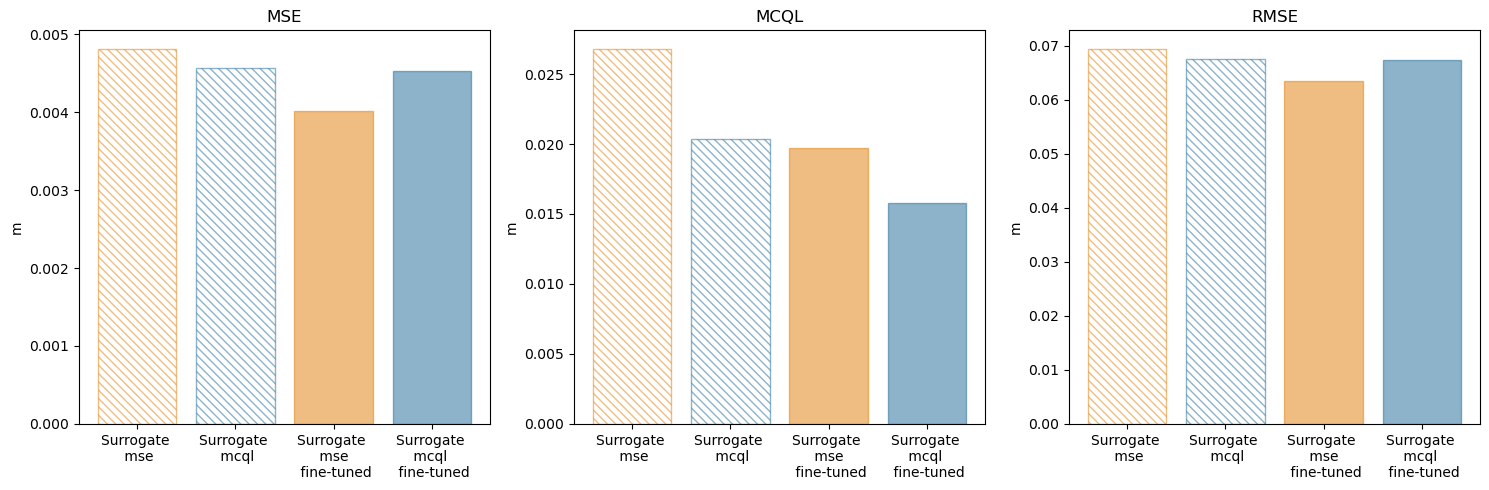

In [12]:

# Nomi delle sezioni e dei valori
sections = ['MSE', 'MCQL', 'RMSE']
values = ['Surrogate \n mse', 'Surrogate \n mcql', 'Surrogate \n mse \n fine-tuned', 'Surrogate \n mcql  \n fine-tuned']
patterns = ['\\\\\\\\', '\\\\\\\\', None, None]

# Creazione del subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop attraverso le sezioni
for i, ax in enumerate(axes):
    ax.bar(values, average_scores[i], color=["w", "w", palette_hex_list[6], palette_hex_list[1]], edgecolor=[palette_hex_list[6], palette_hex_list[1], palette_hex_list[6], palette_hex_list[1]], alpha=0.5, hatch=[patterns[0],patterns[1],patterns[2],patterns[3]])
    ax.set_title(sections[i])  # Titolo della sezione
    ax.set_ylabel('m')
    
    # if i == 0:  # Assegna l'etichetta dell'asse y solo al primo subplot
    #     ax.set_ylabel('Scores')
    # if i == 0:
    #     ax.set_ylim(0, 0.007)  # Imposta un limite comune per l'asse y per confronto

# Miglioramenti del layout
plt.tight_layout()
plt.show()


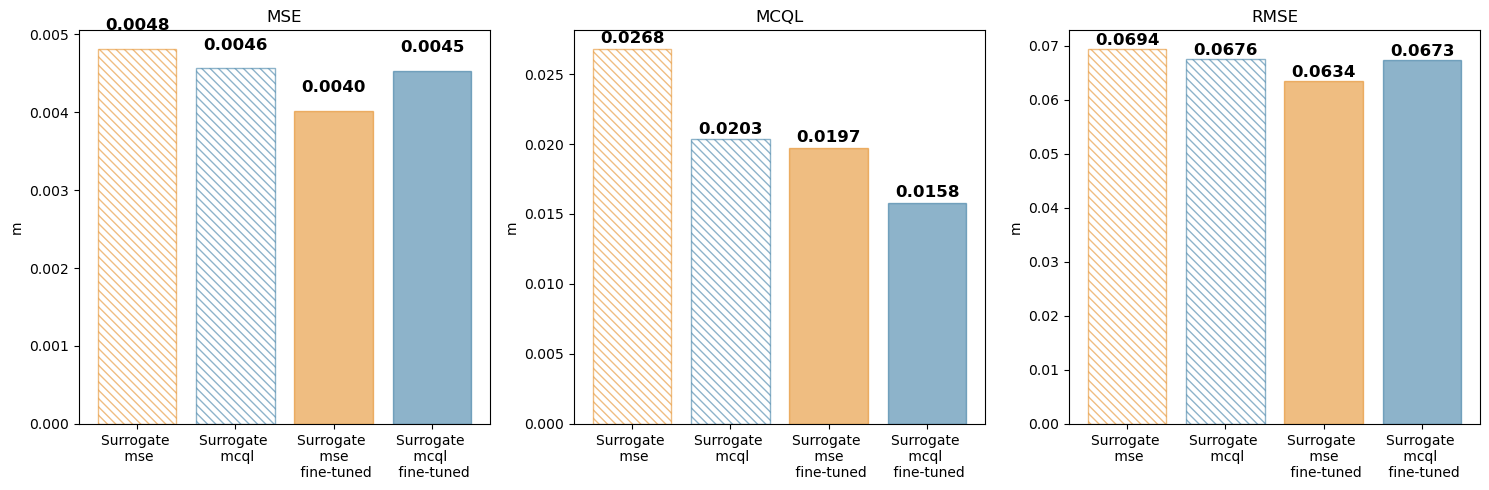

In [13]:
import matplotlib.pyplot as plt

# Nomi delle sezioni e dei valori
sections = ['MSE', 'MCQL', 'RMSE']
values = ['Surrogate \n mse', 'Surrogate \n mcql', 'Surrogate \n mse \n fine-tuned', 'Surrogate \n mcql  \n fine-tuned']
patterns = ['\\\\\\\\', '\\\\\\\\', None, None]

# Creazione del subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop attraverso le sezioni
for i, ax in enumerate(axes):
    bars = ax.bar(values, average_scores[i], 
                  color=["w", "w", palette_hex_list[6], palette_hex_list[1]], 
                  edgecolor=[palette_hex_list[6], palette_hex_list[1], palette_hex_list[6], palette_hex_list[1]], 
                  alpha=0.5, hatch=[patterns[0], patterns[1], patterns[2], patterns[3]])

    ax.set_title(sections[i])  # Titolo della sezione
    ax.set_ylabel('m')

    # Aggiunta del valore sopra ogni barra
    for j, bar in enumerate(bars):
        v = bar.get_height()  # Ottiene l'altezza della barra (valore)
        ax.text(bar.get_x() + bar.get_width() / 2, v + 0.0002, f"{v:.4f}", 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Miglioramenti del layout
plt.tight_layout()
plt.show()


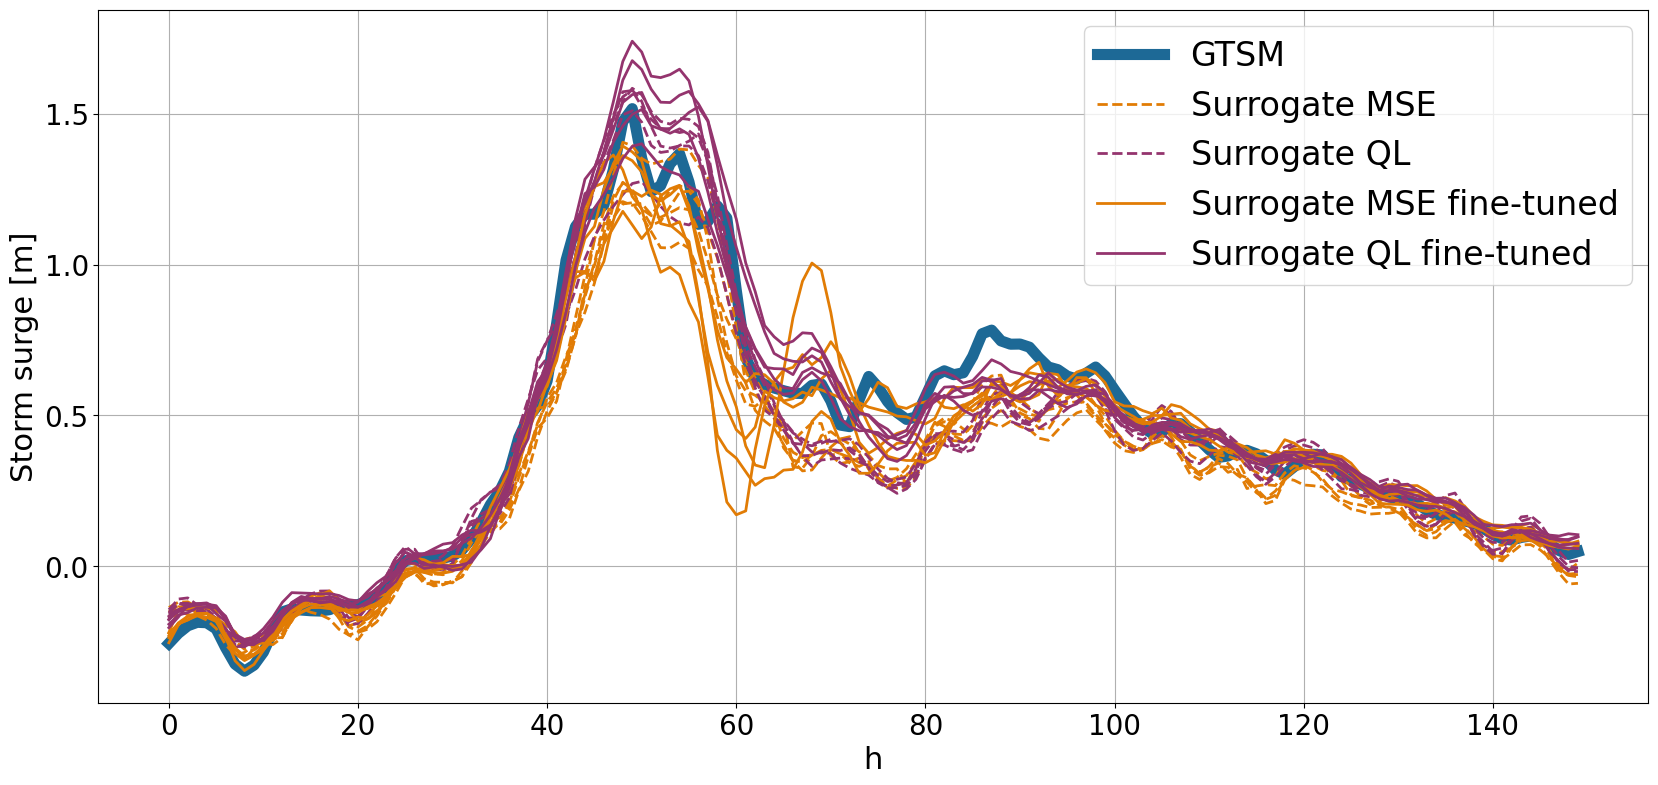

In [14]:
plt.figure(figsize=(20, 9))
# plt.plot( y_train[265900:266150,1], label=f'GTSM',color=palette_hex_list[8])
# plt.plot( y_train_predict[265900:266150,1], label=f'Neural-surrogate',color=palette_hex_list[8])
plt.plot( GTSM_traj[0][0][1][0][87375:87525], label=f'GTSM',color=palette_hex_list[1],linewidth=8)
plt.plot( SURROGATE_traj[0][0][1][0][87375:87525], label=f'Surrogate MSE',color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][1][1][0][87375:87525],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][2][1][0][87375:87525],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][3][1][0][87375:87525],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][4][1][0][87375:87525],color=palette_hex_list[6],linewidth=2,linestyle='--')

plt.plot( SURROGATE_traj[1][0][1][0][87375:87525], label=f'Surrogate QL',color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][1][1][0][87375:87525],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][2][1][0][87375:87525],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][3][1][0][87375:87525],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][4][1][0][87375:87525],color=palette_hex_list[8],linewidth=2,linestyle='--')

plt.plot( SURROGATE_traj[2][0][1][0][87375:87525], label=f'Surrogate MSE fine-tuned',color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][1][1][0][87375:87525],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][2][1][0][87375:87525],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][3][1][0][87375:87525],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][4][1][0][87375:87525],color=palette_hex_list[6],linewidth=2,linestyle='-')

plt.plot( SURROGATE_traj[3][0][1][0][87375:87525], label=f'Surrogate QL fine-tuned',color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][1][1][0][87375:87525],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][2][1][0][87375:87525],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][3][1][0][87375:87525],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][4][1][0][87375:87525],color=palette_hex_list[8],linewidth=2,linestyle='-')


# plt.title('surge')
plt.xlabel('h',fontsize=22)
plt.ylabel("Storm surge [m]",fontsize=22)
plt.legend(fontsize=24)
plt.xticks(fontsize=20)  # Aumenta la dimensione dei numeri sull'asse x
plt.yticks(fontsize=20)  # Aumenta la dimensione dei numeri sull'asse y
plt.grid(True)
# plt.show()
plt.savefig("img_paper/peak1.pdf", format="pdf", bbox_inches="tight", dpi=400)

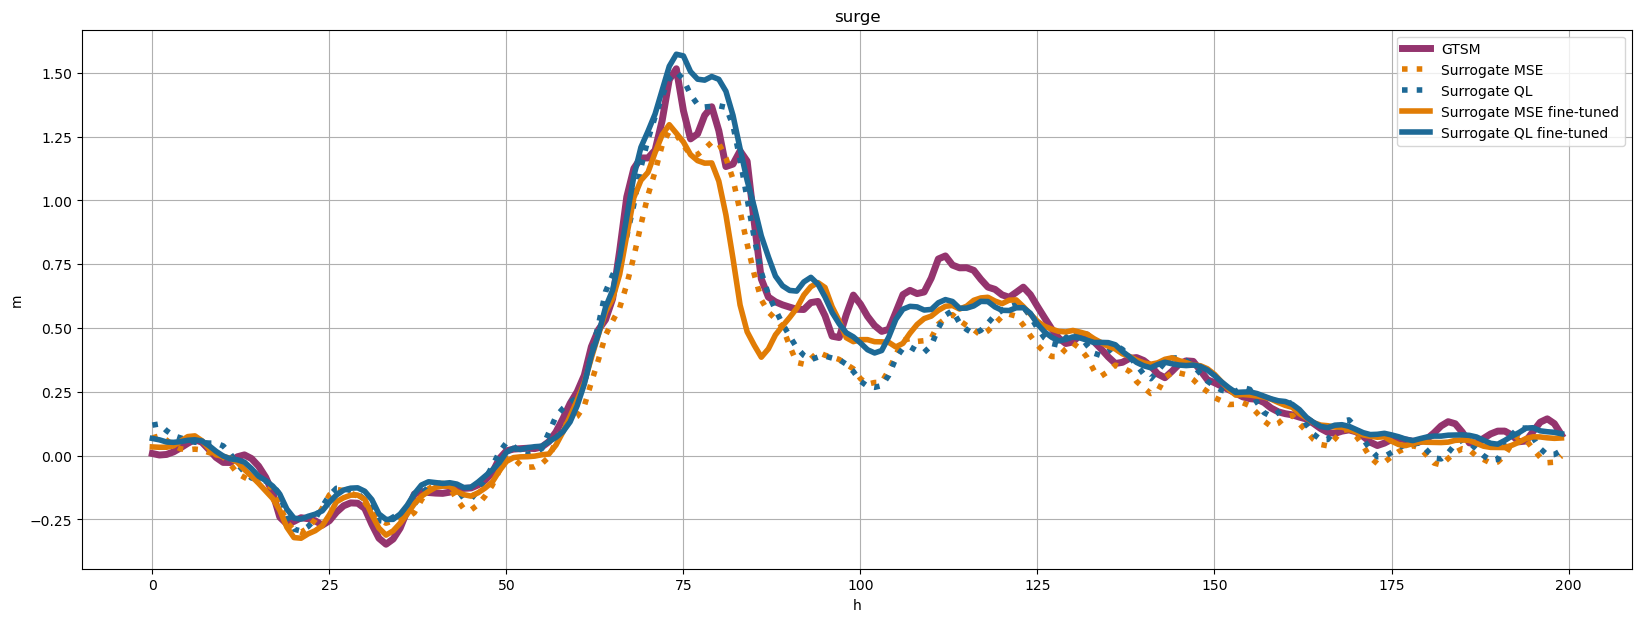

In [15]:
plt.figure(figsize=(20, 7))
# plt.plot( y_train[265900:266150,1], label=f'GTSM',color=palette_hex_list[1])
# plt.plot( y_train_predict[265900:266150,1], label=f'Neural-surrogate',color=palette_hex_list[8])
plt.plot( GTSM_traj[0][0][1][0][87350:87550], label=f'GTSM',color=palette_hex_list[8],linewidth=5)

plt.plot( np.mean(np.array([SURROGATE_traj[0][0][1][0][87350:87550], SURROGATE_traj[0][1][1][0][87350:87550], SURROGATE_traj[0][2][1][0][87350:87550], SURROGATE_traj[0][3][1][0][87350:87550], SURROGATE_traj[0][4][1][0][87350:87550]]), axis=0), 
         label=f'Surrogate MSE',color=palette_hex_list[6],linewidth=4,linestyle=':')
plt.plot( np.mean(np.array([SURROGATE_traj[1][0][1][0][87350:87550], SURROGATE_traj[1][1][1][0][87350:87550], SURROGATE_traj[1][2][1][0][87350:87550], SURROGATE_traj[1][3][1][0][87350:87550], SURROGATE_traj[1][4][1][0][87350:87550]]), axis=0),
         label=f'Surrogate QL',color=palette_hex_list[1],linewidth=4,linestyle=':')
plt.plot( np.mean(np.array([SURROGATE_traj[2][0][1][0][87350:87550], SURROGATE_traj[2][1][1][0][87350:87550], SURROGATE_traj[2][2][1][0][87350:87550], SURROGATE_traj[2][3][1][0][87350:87550], SURROGATE_traj[2][4][1][0][87350:87550]]), axis=0), 
         label=f'Surrogate MSE fine-tuned',color=palette_hex_list[6],linewidth=4,linestyle='-')
plt.plot( np.mean(np.array([SURROGATE_traj[3][0][1][0][87350:87550], SURROGATE_traj[3][1][1][0][87350:87550], SURROGATE_traj[3][2][1][0][87350:87550], SURROGATE_traj[3][3][1][0][87350:87550], SURROGATE_traj[3][4][1][0][87350:87550]]), axis=0), 
         label=f'Surrogate QL fine-tuned',color=palette_hex_list[1],linewidth=4,linestyle='-')


plt.title('surge')
plt.xlabel('h')
plt.ylabel('m')
plt.legend()
plt.grid(True)
plt.show()

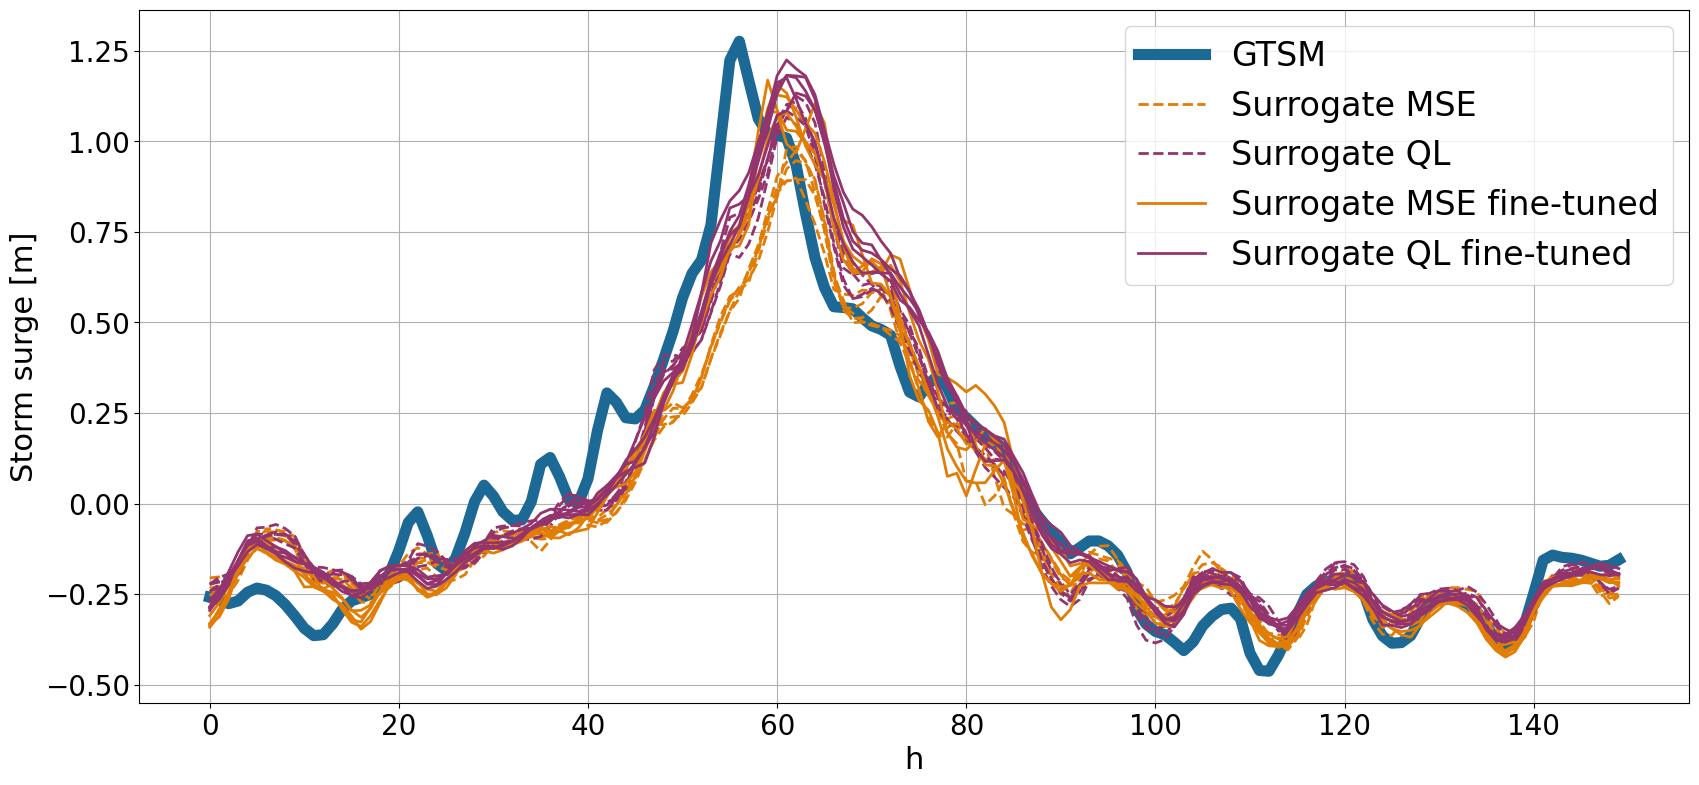

In [16]:
plt.figure(figsize=(20, 9))
# plt.plot( y_train[265900:266150,1], label=f'GTSM',color=palette_hex_list[8])
# plt.plot( y_train_predict[265900:266150,1], label=f'Neural-surrogate',color=palette_hex_list[8])
plt.plot( GTSM_traj[0][0][1][0][41800:41950], label=f'GTSM',color=palette_hex_list[1],linewidth=8)
plt.plot( SURROGATE_traj[0][0][1][0][41800:41950], label=f'Surrogate MSE',color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][1][1][0][41800:41950],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][2][1][0][41800:41950],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][3][1][0][41800:41950],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][4][1][0][41800:41950],color=palette_hex_list[6],linewidth=2,linestyle='--')

plt.plot( SURROGATE_traj[1][0][1][0][41800:41950], label=f'Surrogate QL',color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][1][1][0][41800:41950],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][2][1][0][41800:41950],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][3][1][0][41800:41950],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][4][1][0][41800:41950],color=palette_hex_list[8],linewidth=2,linestyle='--')

plt.plot( SURROGATE_traj[2][0][1][0][41800:41950], label=f'Surrogate MSE fine-tuned',color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][1][1][0][41800:41950],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][2][1][0][41800:41950],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][3][1][0][41800:41950],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][4][1][0][41800:41950],color=palette_hex_list[6],linewidth=2,linestyle='-')

plt.plot( SURROGATE_traj[3][0][1][0][41800:41950], label=f'Surrogate QL fine-tuned',color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][1][1][0][41800:41950],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][2][1][0][41800:41950],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][3][1][0][41800:41950],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][4][1][0][41800:41950],color=palette_hex_list[8],linewidth=2,linestyle='-')


# plt.title('surge')
plt.xlabel('h',fontsize=22)
plt.ylabel("Storm surge [m]",fontsize=22)
plt.legend(fontsize=24)
plt.xticks(fontsize=20)  # Aumenta la dimensione dei numeri sull'asse x
plt.yticks(fontsize=20)  # Aumenta la dimensione dei numeri sull'asse y
plt.grid(True)
# plt.show()
plt.savefig("img_paper/peak2.pdf", format="pdf", bbox_inches="tight", dpi=400)

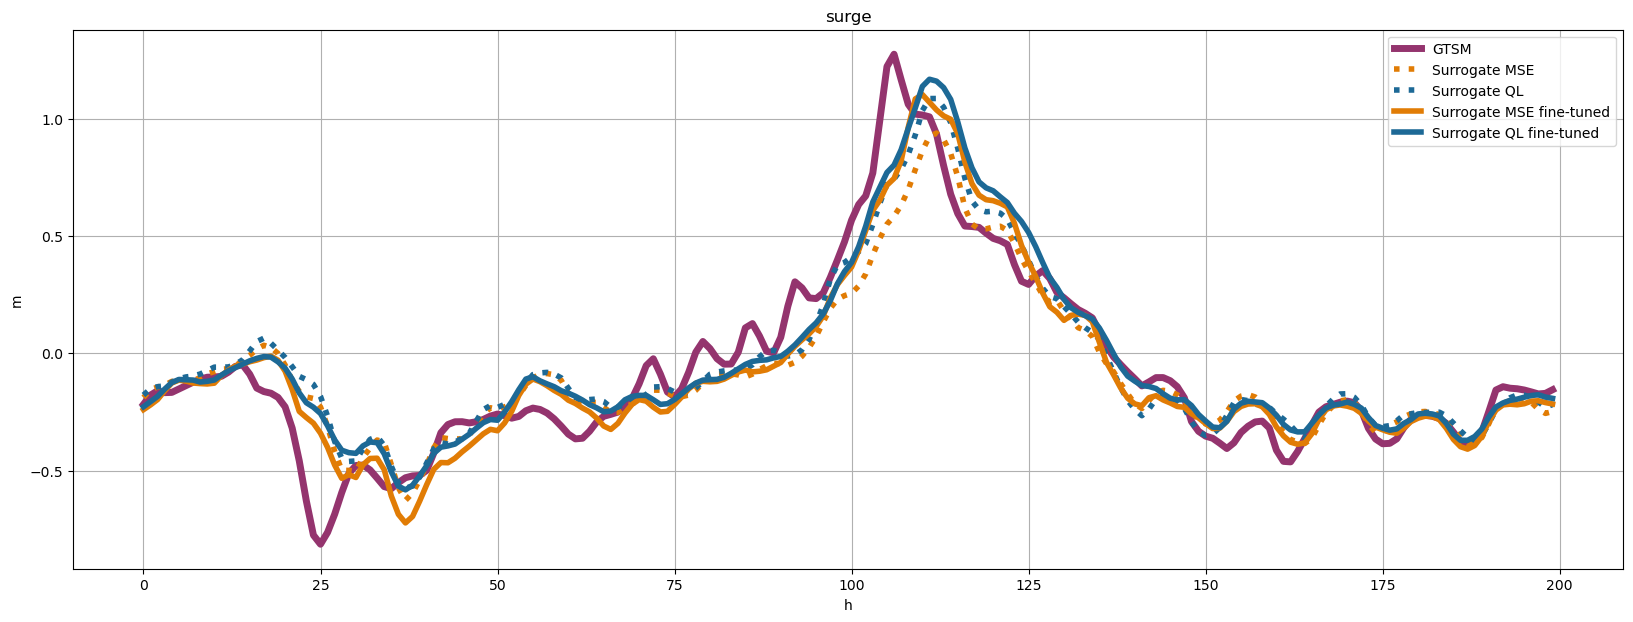

In [17]:
plt.figure(figsize=(20, 7))
# plt.plot( y_train[265900:266150,1], label=f'GTSM',color=palette_hex_list[1])
# plt.plot( y_train_predict[265900:266150,1], label=f'Neural-surrogate',color=palette_hex_list[8])
plt.plot( GTSM_traj[0][0][1][0][41750:41950], label=f'GTSM',color=palette_hex_list[8],linewidth=5)

plt.plot( np.mean(np.array([SURROGATE_traj[0][0][1][0][41750:41950], SURROGATE_traj[0][1][1][0][41750:41950], SURROGATE_traj[0][2][1][0][41750:41950], SURROGATE_traj[0][3][1][0][41750:41950], SURROGATE_traj[0][4][1][0][41750:41950]]), axis=0), 
         label=f'Surrogate MSE',color=palette_hex_list[6],linewidth=4,linestyle=':')
plt.plot( np.mean(np.array([SURROGATE_traj[1][0][1][0][41750:41950], SURROGATE_traj[1][1][1][0][41750:41950], SURROGATE_traj[1][2][1][0][41750:41950], SURROGATE_traj[1][3][1][0][41750:41950], SURROGATE_traj[1][4][1][0][41750:41950]]), axis=0),
         label=f'Surrogate QL',color=palette_hex_list[1],linewidth=4,linestyle=':')
plt.plot( np.mean(np.array([SURROGATE_traj[2][0][1][0][41750:41950], SURROGATE_traj[2][1][1][0][41750:41950], SURROGATE_traj[2][2][1][0][41750:41950], SURROGATE_traj[2][3][1][0][41750:41950], SURROGATE_traj[2][4][1][0][41750:41950]]), axis=0), 
         label=f'Surrogate MSE fine-tuned',color=palette_hex_list[6],linewidth=4,linestyle='-')
plt.plot( np.mean(np.array([SURROGATE_traj[3][0][1][0][41750:41950], SURROGATE_traj[3][1][1][0][41750:41950], SURROGATE_traj[3][2][1][0][41750:41950], SURROGATE_traj[3][3][1][0][41750:41950], SURROGATE_traj[3][4][1][0][41750:41950]]), axis=0), 
         label=f'Surrogate QL fine-tuned',color=palette_hex_list[1],linewidth=4,linestyle='-')


plt.title('surge')
plt.xlabel('h')
plt.ylabel('m')
plt.legend()
plt.grid(True)
plt.show()

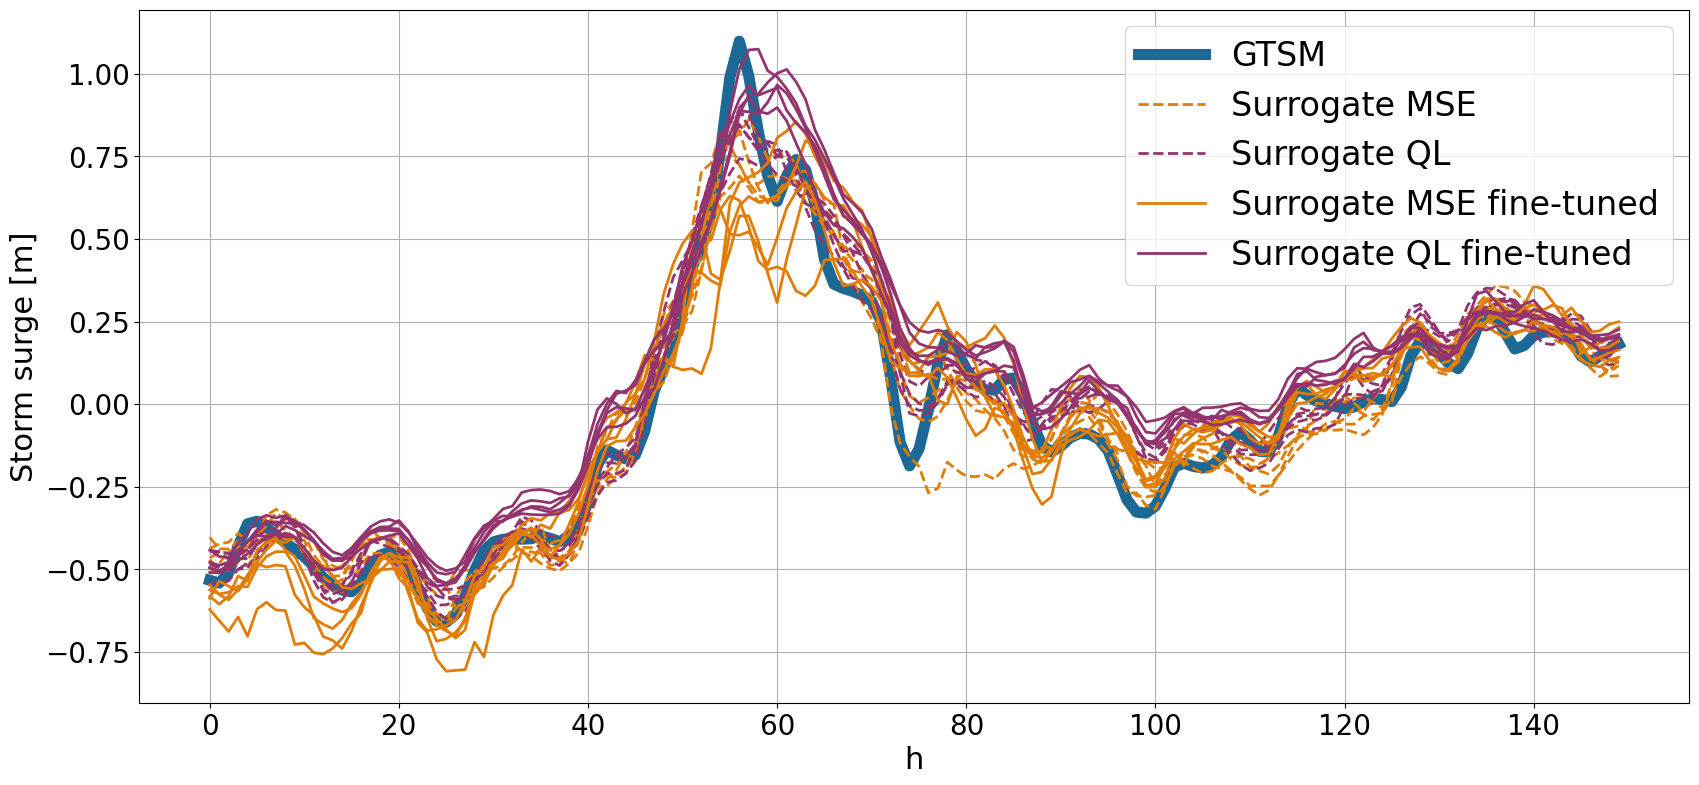

In [18]:
plt.figure(figsize=(20, 9))
# plt.plot( y_train[265900:266150,1], label=f'GTSM',color=palette_hex_list[8])
# plt.plot( y_train_predict[265900:266150,1], label=f'Neural-surrogate',color=palette_hex_list[8])
plt.plot( GTSM_traj[0][0][1][0][298700:298850], label=f'GTSM',color=palette_hex_list[1],linewidth=8)
plt.plot( SURROGATE_traj[0][0][1][0][298700:298850], label=f'Surrogate MSE',color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][1][1][0][298700:298850],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][2][1][0][298700:298850],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][3][1][0][298700:298850],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][4][1][0][298700:298850],color=palette_hex_list[6],linewidth=2,linestyle='--')

plt.plot( SURROGATE_traj[1][0][1][0][298700:298850], label=f'Surrogate QL',color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][1][1][0][298700:298850],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][2][1][0][298700:298850],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][3][1][0][298700:298850],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][4][1][0][298700:298850],color=palette_hex_list[8],linewidth=2,linestyle='--')

plt.plot( SURROGATE_traj[2][0][1][0][298700:298850], label=f'Surrogate MSE fine-tuned',color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][1][1][0][298700:298850],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][2][1][0][298700:298850],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][3][1][0][298700:298850],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][4][1][0][298700:298850],color=palette_hex_list[6],linewidth=2,linestyle='-')

plt.plot( SURROGATE_traj[3][0][1][0][298700:298850], label=f'Surrogate QL fine-tuned',color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][1][1][0][298700:298850],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][2][1][0][298700:298850],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][3][1][0][298700:298850],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][4][1][0][298700:298850],color=palette_hex_list[8],linewidth=2,linestyle='-')


# plt.title('surge')
plt.xlabel('h',fontsize=22)
plt.ylabel("Storm surge [m]",fontsize=22)
plt.legend(fontsize=24)
plt.xticks(fontsize=20)  # Aumenta la dimensione dei numeri sull'asse x
plt.yticks(fontsize=20)  # Aumenta la dimensione dei numeri sull'asse y
plt.grid(True)
# plt.show()
plt.savefig("img_paper/peak3.pdf", format="pdf", bbox_inches="tight", dpi=400)

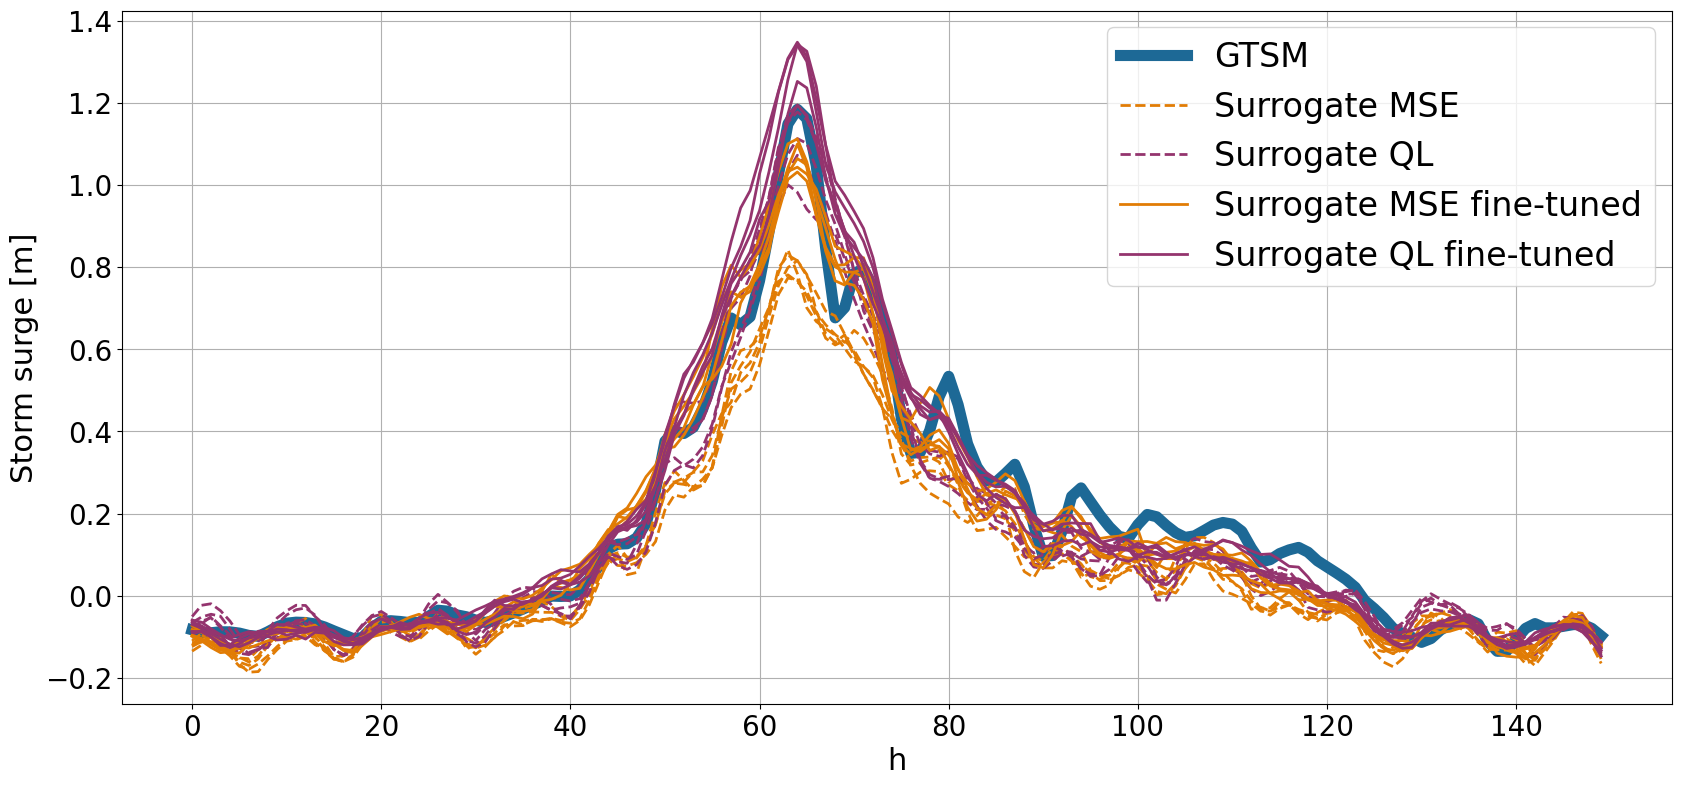

In [19]:
plt.figure(figsize=(20, 9))
# plt.plot( y_train[265900:266150,1], label=f'GTSM',color=palette_hex_list[8])
# plt.plot( y_train_predict[265900:266150,1], label=f'Neural-surrogate',color=palette_hex_list[8])
plt.plot( GTSM_traj[0][0][1][0][94300:94450], label=f'GTSM',color=palette_hex_list[1],linewidth=8)
plt.plot( SURROGATE_traj[0][0][1][0][94300:94450], label=f'Surrogate MSE',color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][1][1][0][94300:94450],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][2][1][0][94300:94450],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][3][1][0][94300:94450],color=palette_hex_list[6],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[0][4][1][0][94300:94450],color=palette_hex_list[6],linewidth=2,linestyle='--')

plt.plot( SURROGATE_traj[1][0][1][0][94300:94450], label=f'Surrogate QL',color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][1][1][0][94300:94450],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][2][1][0][94300:94450],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][3][1][0][94300:94450],color=palette_hex_list[8],linewidth=2,linestyle='--')
plt.plot( SURROGATE_traj[1][4][1][0][94300:94450],color=palette_hex_list[8],linewidth=2,linestyle='--')

plt.plot( SURROGATE_traj[2][0][1][0][94300:94450], label=f'Surrogate MSE fine-tuned',color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][1][1][0][94300:94450],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][2][1][0][94300:94450],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][3][1][0][94300:94450],color=palette_hex_list[6],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[2][4][1][0][94300:94450],color=palette_hex_list[6],linewidth=2,linestyle='-')

plt.plot( SURROGATE_traj[3][0][1][0][94300:94450], label=f'Surrogate QL fine-tuned',color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][1][1][0][94300:94450],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][2][1][0][94300:94450],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][3][1][0][94300:94450],color=palette_hex_list[8],linewidth=2,linestyle='-')
plt.plot( SURROGATE_traj[3][4][1][0][94300:94450],color=palette_hex_list[8],linewidth=2,linestyle='-')


# plt.title('surge')
plt.xlabel('h',fontsize=22)
plt.ylabel("Storm surge [m]",fontsize=22)
plt.legend(fontsize=24)
plt.xticks(fontsize=20)  # Aumenta la dimensione dei numeri sull'asse x
plt.yticks(fontsize=20)  # Aumenta la dimensione dei numeri sull'asse y
plt.grid(True)
# plt.show()
plt.savefig("img_paper/peak4.pdf", format="pdf", bbox_inches="tight", dpi=400)

/var/folders/ts/lzpb36js55j1b5dnrgsxf49h0000gn/T/ipykernel_24330/1536301637.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('quantile_bin')['rmse'].agg(


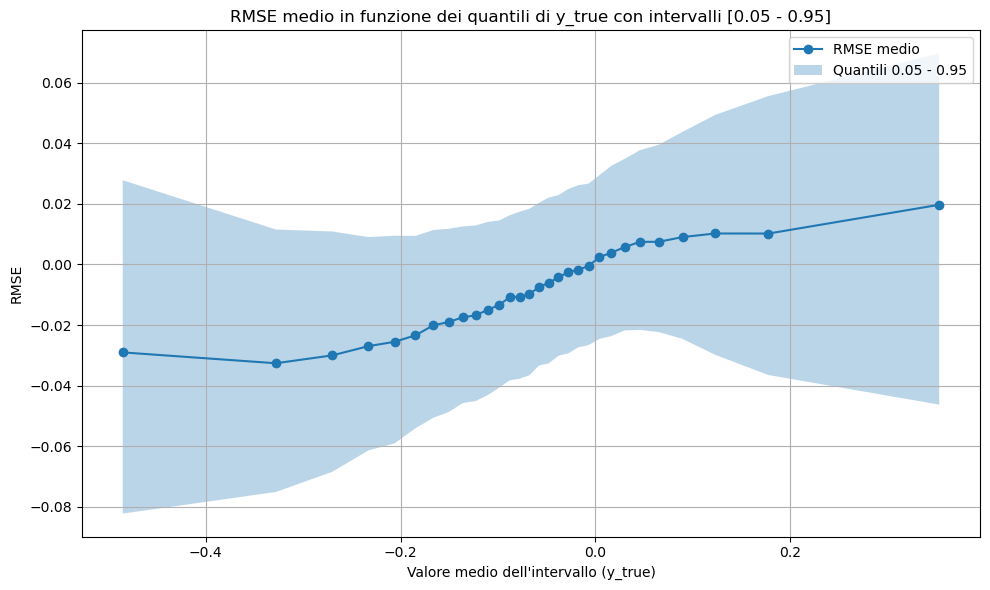

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo di avere queste due traiettorie
y_true = GTSM_traj[0][0][1][0][:]  # traiettoria reale
y_pred = SURROGATE_traj[2][0][1][0][:] # traiettoria stimata

y_true = np.delete(y_true, np.s_[265900:266150])
y_pred = np.delete(y_pred, np.s_[265900:266150])

# Calcolo RMSE punto per punto
errors = (y_true - y_pred)
rmse_pointwise = errors

# Costruiamo un DataFrame
df = pd.DataFrame({
    'y_true': y_true,
    'rmse': rmse_pointwise
})

# Suddividiamo y_true in quantili (es. 10 intervalli con lo stesso numero di punti)
df['quantile_bin'] = pd.qcut(df['y_true'], q=30, duplicates='drop')

# Calcolo dei valori medi e quantili del RMSE per ciascun intervallo
grouped = df.groupby('quantile_bin')['rmse'].agg(
    rmse_mean='mean',
    rmse_q05=lambda x: np.quantile(x, 0.25),
    rmse_q95=lambda x: np.quantile(x, 0.75),
    y_center=lambda x: np.mean(df.loc[x.index, 'y_true'])  # centro dell'intervallo
).reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(grouped['y_center'], grouped['rmse_mean'], marker='o', label='RMSE medio')
plt.fill_between(grouped['y_center'], grouped['rmse_q05'], grouped['rmse_q95'], alpha=0.3, label='Quantili 0.05 - 0.95')
plt.xlabel("Valore medio dell'intervallo (y_true)")
plt.ylabel("RMSE")
plt.title("RMSE medio in funzione dei quantili di y_true con intervalli [0.05 - 0.95]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/ts/lzpb36js55j1b5dnrgsxf49h0000gn/T/ipykernel_24330/870924378.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_all.groupby(['metodo', 'quantile_bin']).agg(


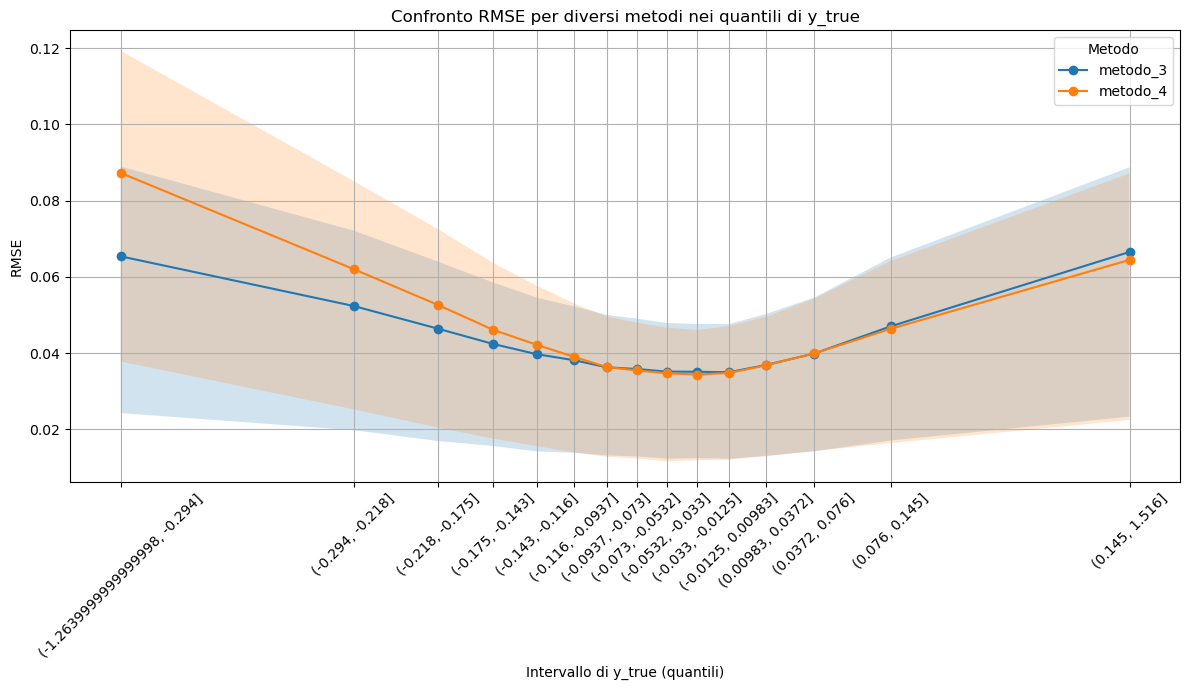

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo di avere queste due traiettorie
y_true = GTSM_traj[0][0][1][0][:]  # traiettoria reale
y_pred = SURROGATE_traj # traiettoria stimata

y_true = np.delete(y_true, np.s_[265900:266150], axis=-1)
y_pred = np.delete(y_pred, np.s_[265900:266150], axis=-1)


# # Dizionario con i 4 metodi, ciascuno con 5 traiettorie
# y_preds_dict = {
#     'metodo_1': [y_pred[0][0][1][0][:], y_pred[0][1][1][0][:], y_pred[0][2][1][0][:], y_pred[0][3][1][0][:],y_pred[0][4][1][0][:]],
#     'metodo_2': [y_pred[1][0][1][0][:], y_pred[1][1][1][0][:], y_pred[1][2][1][0][:], y_pred[1][3][1][0][:],y_pred[1][4][1][0][:]],
#     'metodo_3': [y_pred[2][0][1][0][:], y_pred[2][1][1][0][:], y_pred[2][2][1][0][:], y_pred[2][3][1][0][:],y_pred[2][4][1][0][:]],
#     'metodo_4': [y_pred[3][0][1][0][:], y_pred[3][1][1][0][:], y_pred[3][2][1][0][:], y_pred[3][3][1][0][:],y_pred[3][4][1][0][:]]
# }

# Dizionario con i 4 metodi, ciascuno con 5 traiettorie
y_preds_dict = {
    'metodo_3': [y_pred[2][0][1][0][:], y_pred[2][1][1][0][:], y_pred[2][2][1][0][:], y_pred[2][3][1][0][:],y_pred[2][4][1][0][:]],
    'metodo_4': [y_pred[3][0][1][0][:], y_pred[3][1][1][0][:], y_pred[3][2][1][0][:], y_pred[3][3][1][0][:],y_pred[3][4][1][0][:]]
}

# Creiamo il DataFrame complessivo
all_data = []

for metodo, traiettorie in y_preds_dict.items():
    for i, y_pred in enumerate(traiettorie):
        rmse_pointwise = np.sqrt((y_true - y_pred)**2)
        df_temp = pd.DataFrame({
            'y_true': y_true,
            'rmse': rmse_pointwise,
            'model': f'{metodo}_run{i+1}',
            'metodo': metodo
        })
        all_data.append(df_temp)

# Concatenazione
df_all = pd.concat(all_data, ignore_index=True)

# Quantili comuni a tutti i metodi
df_all['quantile_bin'] = pd.qcut(df_all['y_true'], q=15, duplicates='drop')

# Raggruppamento per metodo e quantile
grouped = df_all.groupby(['metodo', 'quantile_bin']).agg(
    rmse_mean=('rmse', 'mean'),
    rmse_q05=('rmse', lambda x: np.quantile(x, 0.25)),
    rmse_q95=('rmse', lambda x: np.quantile(x, 0.75)),
    y_center=('y_true', 'mean')
).reset_index()

plt.figure(figsize=(12, 7))

for metodo in grouped['metodo'].unique():
    sub = grouped[grouped['metodo'] == metodo]

    x = sub['y_center']
    y = sub['rmse_mean']
    y_min = sub['rmse_q05']
    y_max = sub['rmse_q95']

    plt.plot(x, y, marker='o', label=f'{metodo}')
    plt.fill_between(x, y_min, y_max, alpha=0.2)

# Sostituiamo le etichette dell’asse x con i nomi dei quantili
xticks = grouped['y_center'].unique()
xticklabels = grouped.drop_duplicates('y_center').sort_values('y_center')['quantile_bin'].astype(str)

plt.xticks(ticks=xticks, labels=xticklabels, rotation=45)

plt.xlabel("Intervallo di y_true (quantili)")
plt.ylabel("RMSE")
plt.title("Confronto RMSE per diversi metodi nei quantili di y_true")
plt.legend(title='Metodo')
plt.grid(True)
plt.tight_layout()
plt.show()



/var/folders/ts/lzpb36js55j1b5dnrgsxf49h0000gn/T/ipykernel_24330/2639972821.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_all.groupby(['metodo', 'quantile_bin']).agg(


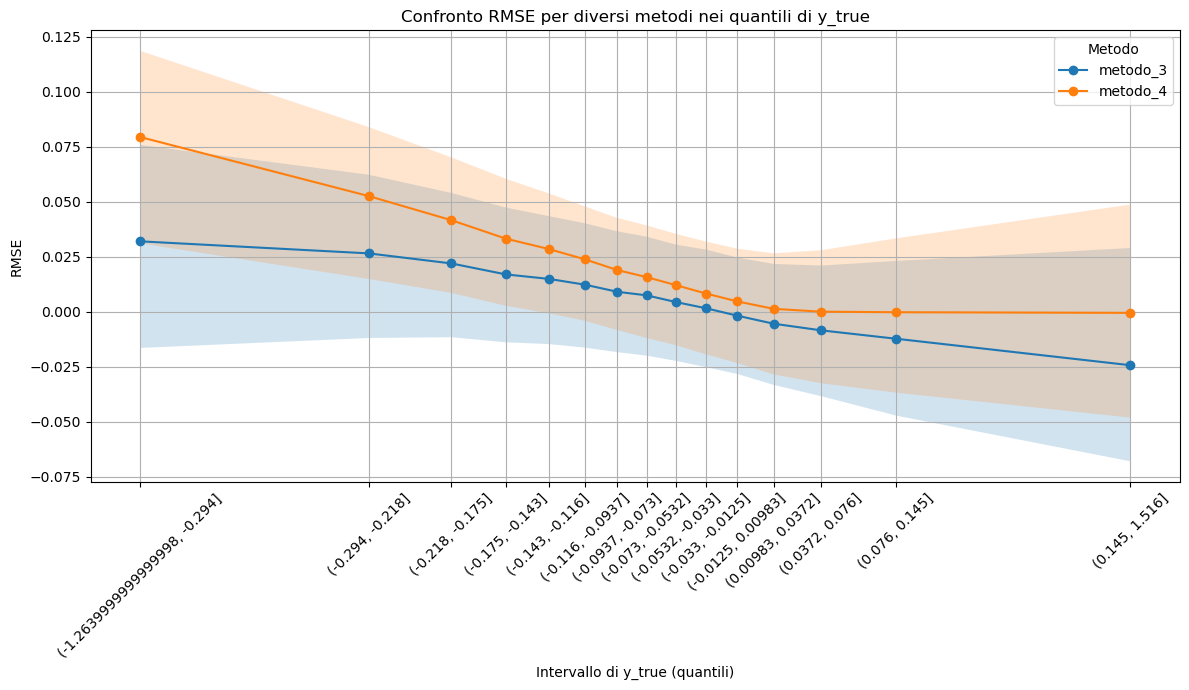

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo di avere queste due traiettorie
y_true = GTSM_traj[0][0][1][0][:]  # traiettoria reale
y_pred = SURROGATE_traj # traiettoria stimata

y_true = np.delete(y_true, np.s_[265900:266150], axis=-1)
y_pred = np.delete(y_pred, np.s_[265900:266150], axis=-1)


# # Dizionario con i 4 metodi, ciascuno con 5 traiettorie
# y_preds_dict = {
#     'metodo_1': [y_pred[0][0][1][0][:], y_pred[0][1][1][0][:], y_pred[0][2][1][0][:], y_pred[0][3][1][0][:],y_pred[0][4][1][0][:]],
#     'metodo_2': [y_pred[1][0][1][0][:], y_pred[1][1][1][0][:], y_pred[1][2][1][0][:], y_pred[1][3][1][0][:],y_pred[1][4][1][0][:]],
#     'metodo_3': [y_pred[2][0][1][0][:], y_pred[2][1][1][0][:], y_pred[2][2][1][0][:], y_pred[2][3][1][0][:],y_pred[2][4][1][0][:]],
#     'metodo_4': [y_pred[3][0][1][0][:], y_pred[3][1][1][0][:], y_pred[3][2][1][0][:], y_pred[3][3][1][0][:],y_pred[3][4][1][0][:]]
# }

# Dizionario con i 4 metodi, ciascuno con 5 traiettorie
y_preds_dict = {
    'metodo_3': [y_pred[2][0][1][0][:], y_pred[2][1][1][0][:], y_pred[2][2][1][0][:], y_pred[2][3][1][0][:],y_pred[2][4][1][0][:]],
    'metodo_4': [y_pred[3][0][1][0][:], y_pred[3][1][1][0][:], y_pred[3][2][1][0][:], y_pred[3][3][1][0][:],y_pred[3][4][1][0][:]]
}

# Creiamo il DataFrame complessivo
all_data = []

for metodo, traiettorie in y_preds_dict.items():
    for i, y_pred in enumerate(traiettorie):
        rmse_pointwise = (y_pred - y_true)
        df_temp = pd.DataFrame({
            'y_true': y_true,
            'rmse': rmse_pointwise,
            'model': f'{metodo}_run{i+1}',
            'metodo': metodo
        })
        all_data.append(df_temp)

# Concatenazione
df_all = pd.concat(all_data, ignore_index=True)

# Quantili comuni a tutti i metodi
df_all['quantile_bin'] = pd.qcut(df_all['y_true'], q=15, duplicates='drop')

# Raggruppamento per metodo e quantile
grouped = df_all.groupby(['metodo', 'quantile_bin']).agg(
    rmse_mean=('rmse', 'mean'),
    rmse_q05=('rmse', lambda x: np.quantile(x, 0.25)),
    rmse_q95=('rmse', lambda x: np.quantile(x, 0.75)),
    y_center=('y_true', 'mean')
).reset_index()

plt.figure(figsize=(12, 7))

for metodo in grouped['metodo'].unique():
    sub = grouped[grouped['metodo'] == metodo]

    x = sub['y_center']
    y = sub['rmse_mean']
    y_min = sub['rmse_q05']
    y_max = sub['rmse_q95']

    plt.plot(x, y, marker='o', label=f'{metodo}')
    plt.fill_between(x, y_min, y_max, alpha=0.2)

# Sostituiamo le etichette dell’asse x con i nomi dei quantili
xticks = grouped['y_center'].unique()
xticklabels = grouped.drop_duplicates('y_center').sort_values('y_center')['quantile_bin'].astype(str)

plt.xticks(ticks=xticks, labels=xticklabels, rotation=45)

plt.xlabel("Intervallo di y_true (quantili)")
plt.ylabel("RMSE")
plt.title("Confronto RMSE per diversi metodi nei quantili di y_true")
plt.legend(title='Metodo')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/ts/lzpb36js55j1b5dnrgsxf49h0000gn/T/ipykernel_24330/482113618.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_all.groupby(['metodo', 'bin']).agg(


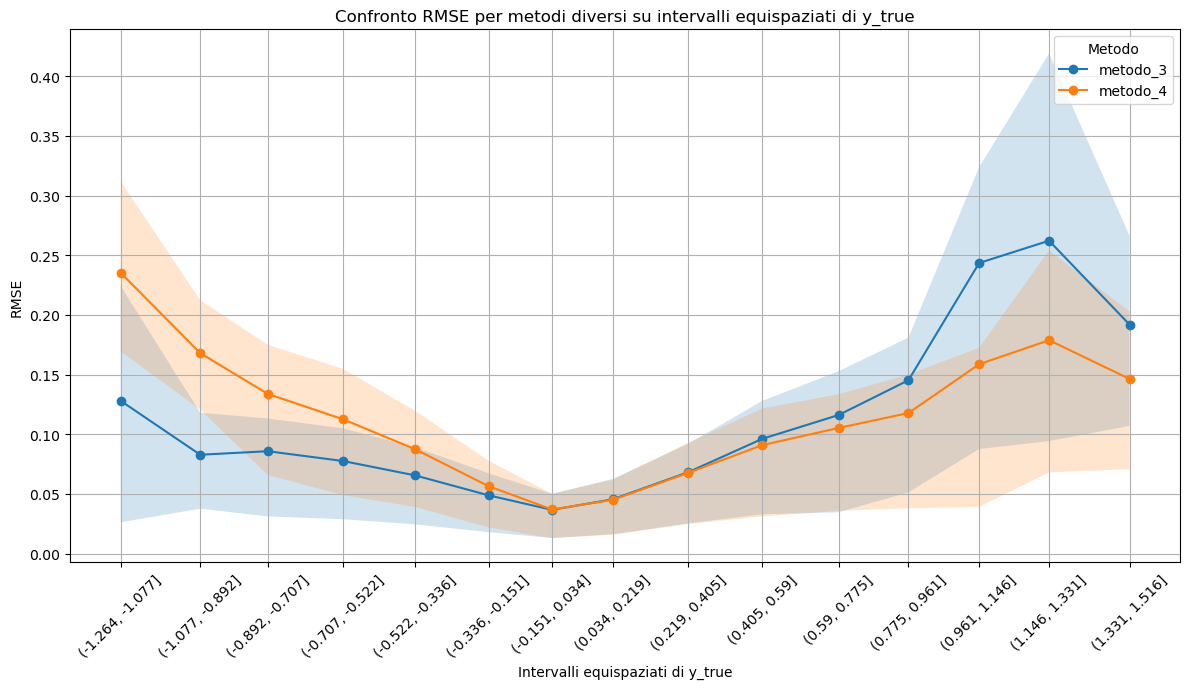

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo di avere queste due traiettorie
y_true = GTSM_traj[0][0][1][0][:]  # traiettoria reale
y_pred = SURROGATE_traj # traiettoria stimata

y_true = np.delete(y_true, np.s_[265900:266150], axis=-1)
y_pred = np.delete(y_pred, np.s_[265900:266150], axis=-1)


# # Dizionario con i 4 metodi, ciascuno con 5 traiettorie
# y_preds_dict = {
#     'metodo_1': [y_pred[0][0][1][0][:], y_pred[0][1][1][0][:], y_pred[0][2][1][0][:], y_pred[0][3][1][0][:],y_pred[0][4][1][0][:]],
#     'metodo_2': [y_pred[1][0][1][0][:], y_pred[1][1][1][0][:], y_pred[1][2][1][0][:], y_pred[1][3][1][0][:],y_pred[1][4][1][0][:]],
#     'metodo_3': [y_pred[2][0][1][0][:], y_pred[2][1][1][0][:], y_pred[2][2][1][0][:], y_pred[2][3][1][0][:],y_pred[2][4][1][0][:]],
#     'metodo_4': [y_pred[3][0][1][0][:], y_pred[3][1][1][0][:], y_pred[3][2][1][0][:], y_pred[3][3][1][0][:],y_pred[3][4][1][0][:]]
# }

# Dizionario con i 4 metodi, ciascuno con 5 traiettorie
y_preds_dict = {
    'metodo_3': [y_pred[2][0][1][0][:], y_pred[2][1][1][0][:], y_pred[2][2][1][0][:], y_pred[2][3][1][0][:],y_pred[2][4][1][0][:]],
    'metodo_4': [y_pred[3][0][1][0][:], y_pred[3][1][1][0][:], y_pred[3][2][1][0][:], y_pred[3][3][1][0][:],y_pred[3][4][1][0][:]]
}
# Parametro: numero di intervalli equispaziati
n_bins = 15

# Calcolo dei limiti dell’intervallo
min_val = np.min(y_true)
max_val = np.max(y_true)
bins = np.linspace(min_val, max_val, n_bins + 1)

# Dataset complessivo
all_data = []

for metodo, traiettorie in y_preds_dict.items():
    for i, y_pred in enumerate(traiettorie):
        rmse_pointwise = np.sqrt((y_true - y_pred)**2)
        df_temp = pd.DataFrame({
            'y_true': y_true,
            'rmse': rmse_pointwise,
            'model': f'{metodo}_run{i+1}',
            'metodo': metodo
        })
        all_data.append(df_temp)

df_all = pd.concat(all_data, ignore_index=True)

# Suddivisione in intervalli equispaziati
df_all['bin'] = pd.cut(df_all['y_true'], bins=bins, include_lowest=True)

# Raggruppamento e statistiche
grouped = df_all.groupby(['metodo', 'bin']).agg(
    rmse_mean=('rmse', 'mean'),
    rmse_q05=('rmse', lambda x: np.quantile(x, 0.25)),
    rmse_q95=('rmse', lambda x: np.quantile(x, 0.75)),
    y_center=('y_true', 'mean')
).reset_index()
# Funzione per etichettare gli intervalli arrotondati
def format_interval(interval):
    left = round(interval.left, 3)
    right = round(interval.right, 3)
    return f"({left}, {right}]"

plt.figure(figsize=(12, 7))

for metodo in grouped['metodo'].unique():
    sub = grouped[grouped['metodo'] == metodo]

    x = sub['y_center']
    y = sub['rmse_mean']
    y_min = sub['rmse_q05']
    y_max = sub['rmse_q95']

    plt.plot(x, y, marker='o', label=f'{metodo}')
    plt.fill_between(x, y_min, y_max, alpha=0.2)

# Etichette degli intervalli
xticks = grouped['y_center'].unique()
xticklabels = grouped.drop_duplicates('y_center').sort_values('y_center')['bin'].apply(format_interval)

plt.xticks(ticks=xticks, labels=xticklabels, rotation=45)
plt.xlabel("Intervalli equispaziati di y_true")
plt.ylabel("RMSE")
plt.title("Confronto RMSE per metodi diversi su intervalli equispaziati di y_true")
plt.legend(title='Metodo')
plt.grid(True)
plt.tight_layout()
plt.show()



/var/folders/ts/lzpb36js55j1b5dnrgsxf49h0000gn/T/ipykernel_24330/2387948208.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_all.groupby(['metodo', 'bin']).agg(


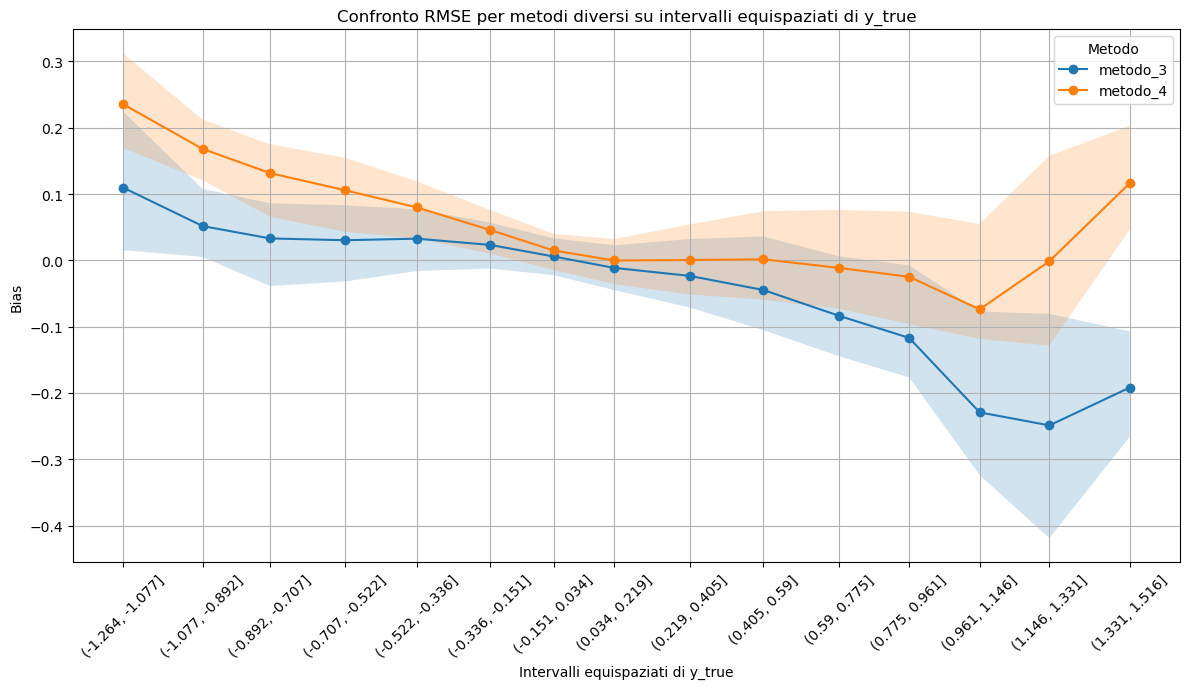

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo di avere queste due traiettorie
y_true = GTSM_traj[0][0][1][0][:]  # traiettoria reale
y_pred = SURROGATE_traj # traiettoria stimata

y_true = np.delete(y_true, np.s_[265900:266150], axis=-1)
y_pred = np.delete(y_pred, np.s_[265900:266150], axis=-1)


# # Dizionario con i 4 metodi, ciascuno con 5 traiettorie
# y_preds_dict = {
#     'metodo_1': [y_pred[0][0][1][0][:], y_pred[0][1][1][0][:], y_pred[0][2][1][0][:], y_pred[0][3][1][0][:],y_pred[0][4][1][0][:]],
#     'metodo_2': [y_pred[1][0][1][0][:], y_pred[1][1][1][0][:], y_pred[1][2][1][0][:], y_pred[1][3][1][0][:],y_pred[1][4][1][0][:]],
#     'metodo_3': [y_pred[2][0][1][0][:], y_pred[2][1][1][0][:], y_pred[2][2][1][0][:], y_pred[2][3][1][0][:],y_pred[2][4][1][0][:]],
#     'metodo_4': [y_pred[3][0][1][0][:], y_pred[3][1][1][0][:], y_pred[3][2][1][0][:], y_pred[3][3][1][0][:],y_pred[3][4][1][0][:]]
# }

# Dizionario con i 4 metodi, ciascuno con 5 traiettorie
y_preds_dict = {
    'metodo_3': [y_pred[2][0][1][0][:], y_pred[2][1][1][0][:], y_pred[2][2][1][0][:], y_pred[2][3][1][0][:],y_pred[2][4][1][0][:]],
    'metodo_4': [y_pred[3][0][1][0][:], y_pred[3][1][1][0][:], y_pred[3][2][1][0][:], y_pred[3][3][1][0][:],y_pred[3][4][1][0][:]]
}
# Parametro: numero di intervalli equispaziati
n_bins = 15

# Calcolo dei limiti dell’intervallo
min_val = np.min(y_true)
max_val = np.max(y_true)
bins = np.linspace(min_val, max_val, n_bins + 1)

# Dataset complessivo
all_data = []

for metodo, traiettorie in y_preds_dict.items():
    for i, y_pred in enumerate(traiettorie):
        rmse_pointwise = y_pred - y_true
        df_temp = pd.DataFrame({
            'y_true': y_true,
            'rmse': rmse_pointwise,
            'model': f'{metodo}_run{i+1}',
            'metodo': metodo
        })
        all_data.append(df_temp)

df_all = pd.concat(all_data, ignore_index=True)

# Suddivisione in intervalli equispaziati
df_all['bin'] = pd.cut(df_all['y_true'], bins=bins, include_lowest=True)

# Raggruppamento e statistiche
grouped = df_all.groupby(['metodo', 'bin']).agg(
    rmse_mean=('rmse', 'mean'),
    rmse_q05=('rmse', lambda x: np.quantile(x, 0.25)),
    rmse_q95=('rmse', lambda x: np.quantile(x, 0.75)),
    y_center=('y_true', 'mean')
).reset_index()
# Funzione per etichettare gli intervalli arrotondati
def format_interval(interval):
    left = round(interval.left, 3)
    right = round(interval.right, 3)
    return f"({left}, {right}]"

plt.figure(figsize=(12, 7))

for metodo in grouped['metodo'].unique():
    sub = grouped[grouped['metodo'] == metodo]

    x = sub['y_center']
    y = sub['rmse_mean']
    y_min = sub['rmse_q05']
    y_max = sub['rmse_q95']

    plt.plot(x, y, marker='o', label=f'{metodo}')
    plt.fill_between(x, y_min, y_max, alpha=0.2)

# Etichette degli intervalli
xticks = grouped['y_center'].unique()
xticklabels = grouped.drop_duplicates('y_center').sort_values('y_center')['bin'].apply(format_interval)

plt.xticks(ticks=xticks, labels=xticklabels, rotation=45)
plt.xlabel("Intervalli equispaziati di y_true")
plt.ylabel("Bias")
plt.title("Confronto RMSE per metodi diversi su intervalli equispaziati di y_true")
plt.legend(title='Metodo')
plt.grid(True)
plt.tight_layout()
plt.show()


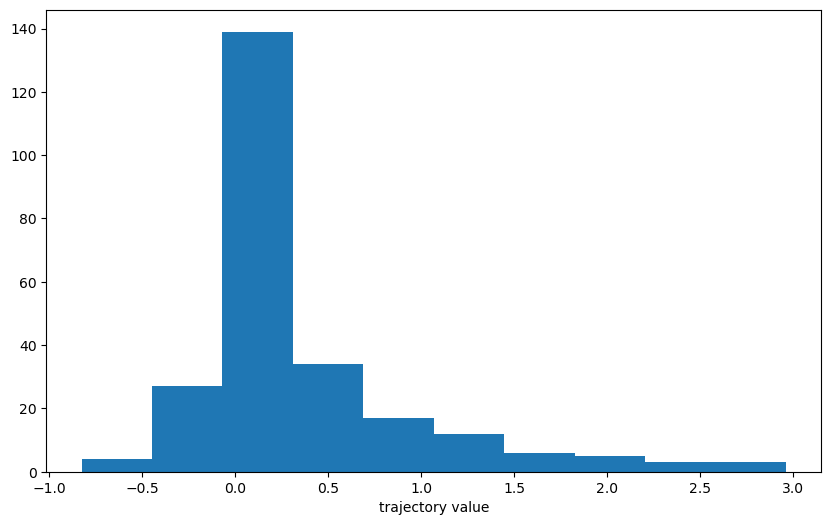

<Figure size 1000x600 with 0 Axes>

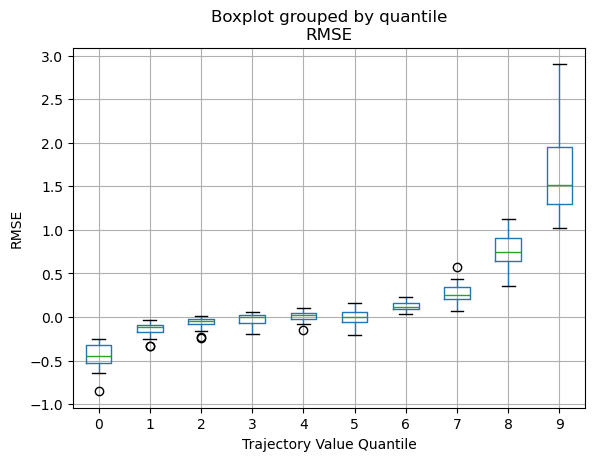

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample trajectory data (replace with your actual data)
trajectory1 = GTSM_traj[0][0][1][0][265900:266150]  # Ground truth
trajectory2 = SURROGATE_traj[0][0][1][0][265900:266150]  # Predicted trajectory add some noise

n_quantiles = 10 # Number of quantiles (e.g., 4 for quartiles)

# Convert data to DataFrame
df = pd.DataFrame({'trajectory_value': trajectory1, 'RMSE': (trajectory1 - trajectory2)})

# Create quantiles using pandas.qcut
df['quantile'] = pd.qcut(df['trajectory_value'], n_quantiles, labels=False)


#Plot a distribution
plt.figure(figsize=(10, 6))
plt.hist(trajectory1,bins=n_quantiles)
plt.xlabel("trajectory value")


# Create box plots
plt.figure(figsize=(10, 6))
df.boxplot(column='RMSE', by='quantile')

plt.xlabel("Trajectory Value Quantile")
plt.ylabel("RMSE")

plt.show()


In [19]:
from pyextremes import get_extremes
from pyextremes import plot_mean_residual_life
from pyextremes import EVA


res_real = [[],[],[],[]]
res_pred = [[],[],[],[]]

def generate_hourly_dates(start_year, start_month, end_year, end_month):
    # Genera una data di inizio e una data di fine
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1, hour=0, minute=0)
    # Calcola l'ultimo giorno del mese di fine
    end_date = pd.Timestamp(year=end_year, month=end_month, day=1, hour=0, minute=0) + pd.offsets.MonthEnd(0) + pd.DateOffset(hour=23, minute=59)
    
    # Genera il vettore di date con passo orario
    date_range = pd.date_range(start=start_date, end=end_date, freq='h')
    return date_range


date_extremes_pred = [[],[],[],[],[]]
date_extremes_real = [[],[],[],[],[]]
exceedances_pred = [[],[],[],[],[]]
exceedances_real = [[],[],[],[],[]]

threshold_surge = np.quantile(y_train[:,1], 0.99)
threshold_surge_pred = np.quantile(y_train_predict[:,1], 0.99)
# threshold_surge = 0.34

# Generazione del vettore di date
start_year = train_y_bounds[0]
start_month = train_month_start_end[0]
end_year = train_y_bounds[1]
end_month = train_month_start_end[1]
dates = generate_hourly_dates(start_year, start_month, end_year, end_month)
# (mancano steps recurrent iniziali)
# dates = dates[(LSTM_recurrent_steps-1):]

palette_list= [palette_hex_list[1],palette_hex_list[3],palette_hex_list[5],palette_hex_list[7],palette_hex_list[9]]

# Creazione dei subplot
#fig, axs = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)

for j in range(0,4):

    color = palette_list[i % len(palette_list)]  # Cicla attraverso i colori
    


    date_range = pd.date_range(start='2016-02-01 00:00', end='2050-12-31 23:00', freq='h')
    # Rimuovere gli ultimi 60 valori del mese di dicembre 2037 per CMCC GCM
    december_2037 = date_range[(date_range.year == 2037) & (date_range.month == 12)]
    # Determinare gli ultimi 60 valori
    last_60_december_2037 = december_2037[-60:]
    # Rimuovere questi valori dal vettore originale
    final_date_range = date_range[~date_range.isin(last_60_december_2037)]



    _real = GTSM_traj[j][0][1][0][:]
    _pred = np.mean([SURROGATE_traj[j][0][1][0][:],
                              SURROGATE_traj[j][1][1][0][:],
                              SURROGATE_traj[j][2][1][0][:],
                              SURROGATE_traj[j][3][1][0][:],
                              SURROGATE_traj[j][4][1][0][:]], axis=0)
    # _pred = np.mean([SURROGATE_traj[0][1][0][:]], axis=0)
    #     
    _real = np.delete(_real, np.s_[265900:266150])
    _pred = np.delete(_pred, np.s_[265900:266150])
    final_date_range = np.delete(final_date_range, np.s_[265900:266150])
    
    ts_real = pd.Series(data=_real, index=final_date_range)
    ts_real = ts_real.groupby(ts_real.index).mean()
    ts_real = ts_real.sort_index()

    model_real = EVA(ts_real)
    model_real.get_extremes( "POT", threshold=threshold_surge, r="24h")
    model_real.fit_model()
    rp_real = model_real.get_summary(
                                        return_period=np.logspace(0, 3, num=1000),
                                        alpha=0.90,
                                        n_samples=1000,
                                    )


    ts_pred = pd.Series(data=_pred, index=final_date_range)
    ts_pred = ts_pred.groupby(ts_pred.index).mean()
    ts_pred = ts_pred.sort_index()

    model_pred = EVA(ts_pred)
    model_pred.get_extremes( "POT", threshold=threshold_surge_pred, r="24h")
    model_pred.fit_model()

    rp_pred = model_pred.get_summary(
                                        return_period=np.logspace(0, 3, num=1000),
                                        alpha=0.90,
                                        n_samples=1000,
                                    )
    res_real[j] = rp_real
    res_pred[j] = rp_pred


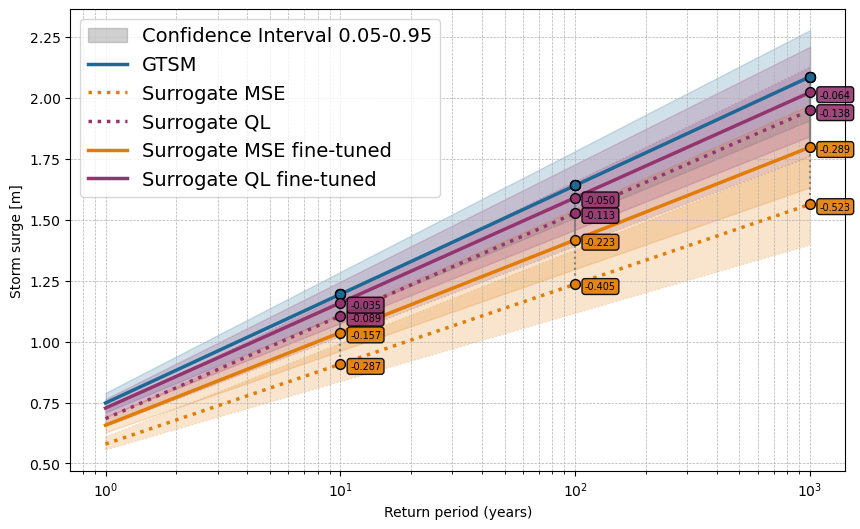

In [20]:
import matplotlib.patches as mpatches
# Plot della mediana e degli intervalli di confidenza
plt.figure(figsize=(10, 6))

# Plot della linea mediana
plt.plot(rp_real.index, rp_real['return value'], color=palette_hex_list[1], linewidth=2.5, label="GTSM")
# Plot dell'area di confidenza (ci) colorata con bordi tratteggiati
plt.fill_between(
    rp_real.index, rp_real['lower ci'], rp_real['upper ci'],
    color=palette_hex_list[1], alpha=0.2, edgecolor=palette_hex_list[1], linestyle='-', linewidth=1
)

colors = [palette_hex_list[6],palette_hex_list[8],palette_hex_list[6],palette_hex_list[8]]
line_style = [":",":","-","-"]
labels_ = ["Surrogate MSE","Surrogate QL","Surrogate MSE fine-tuned","Surrogate QL fine-tuned"]

for j in range(0, 4):
    rp_pred = res_pred[j]
    # Plot della linea mediana
    plt.plot(rp_pred.index, rp_pred['return value'], color=colors[j], linewidth=2.5, label=labels_[j],linestyle=line_style[j])
    # Plot dell'area di confidenza (ci) colorata con bordi tratteggiati
    plt.fill_between(
        rp_pred.index, rp_pred['lower ci'], rp_pred['upper ci'],
        color=colors[j], alpha=0.2, edgecolor=colors[j], linestyle=line_style[j], linewidth=1
    )

    specific_periods = [10, 100, 500, 1000]
    
    # Aggiunta degli scatter per i soli tempi di ritorno specificati e dei segmenti con distanza
    for period in specific_periods:
        if period in rp_real.index and period in rp_pred.index:
            # Valori di return per rp_real e rp_pred
            real_value = rp_real.loc[period, "return value"]
            pred_value = rp_pred.loc[period, "return value"]
            
            # Scatter plot
            plt.scatter(period, real_value, color=palette_hex_list[1], edgecolor="black", s=50, zorder=5)
            plt.scatter(period, pred_value, color=colors[j], edgecolor="black", s=50, zorder=5)
            
            # Linea che collega i punti
            plt.plot([period, period], [real_value, pred_value], color="grey", linestyle=line_style[j], linewidth=1.5)
            
            # Testo con la distanza
            distance = (pred_value - real_value)
            # Posizionamento del testo condizionato su j
            if j < 4:
                ha_position = "left"  # A sinistra per j < 3
                # Aggiungi il testo del bias con il posizionamento specifico
                plt.text(period+period/10, pred_value-0.03, f"{distance:.3f}",
                        ha=ha_position, va="bottom", fontsize=7, color="black",bbox=dict(facecolor=colors[j], edgecolor='black', boxstyle='round,pad=0.3', alpha=0.9))
            else:
                ha_position = "center"  # Centrate per j = 3
                # Aggiungi il testo del bias con il posizionamento specifico
                plt.text(period, real_value+0.05, f"bias: {distance:.4f}",
                        ha=ha_position, va="bottom", fontsize=10, color="black")



# Dettagli del grafico
plt.xlabel("Return period (years)")
plt.ylabel("Storm surge [m]")
plt.xscale("log")
# plt.title("Return period and confidence interval")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
shadow_patch = mpatches.Patch(color=palette_hex_list[11], alpha=0.3, label="Confidence Interval 0.05-0.95")
plt.legend(handles=[shadow_patch] + plt.gca().get_legend_handles_labels()[0], fontsize=14)
# plt.show()
plt.savefig("img_paper/projected_return_values.pdf", format="pdf", bbox_inches="tight", dpi=400)